# Adjusting for Confounding

We cover the standard scenario where an analyst might need to adjust for confounding variables in order to obtain a causal relationship.

We point out that adjusting for variables that are colliders or mediators (i.e., variables that account for the observed relationship between the experimental conditions and the outcome) can result in bias.

Furthermore, we consider the scenario where we don't adjust for some or all of the confounders. We show that this can result in bias.

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd

import statsmodels.api as sm
from scipy import stats
import causal_hri
from causal_hri.data import generate_robotic_assistance_dataset
from causal_hri.estimators import *
import matplotlib.pyplot as plt
from tableone import TableOne
from ananke.graphs import DAG

## Failing to Detect Causal Effects in Observational Data

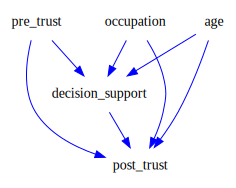

In [24]:
g = DAG(vertices=['decision_support', 'post_trust', 'pre_trust', 'occupation', 
                 'age'], 
       di_edges=[('decision_support', 'post_trust'), ('pre_trust', 'post_trust'), 
                 ('occupation', 'post_trust'), ('pre_trust', 'decision_support'), 
                 ('occupation', 'decision_support'), ('age', 'post_trust'), 
                 ('age', 'decision_support'), ('age', 'post_trust')])

g.draw()

We revisit the experiment investigating the effect of robot-issued versus computer-issued decision support on trust levels. However, in this scenario, instead of the data being collected in a controlled laboratory environment, we collect the data in the field. The variables include:

* "pre_trust": An unweighted average of responses to three questions about trust, on a scale of 0 to 4, taken prior to the start of the study
* "occupation": whether a participant is in a STEM or non-STEM field of study
* "age": age of participant (18-30)
* "decision_support": whether a participant chooses the computer (0) or robot (1) decision support system
* "post_trust": The same trust questionnaire conducted after the study.


This means that subjects in the study have the ability to select the kind of decision support they want. The factors that influence the kind of decision support a subject chooses may also influence their trust level. In this scenario, these factors are trust levels prior to the experiment ("pre_trust"), occupation, and age.

This scenario mimics many contexts in which data are collected observationally, rather than experimentally. For example, we might set up this study in a busy corridor of a university and invite potential study participants to come and interact with the decision support system of their choice.

Compared to the dataset investigated in the previous notebook, nothing about the mechanisms influencing trust have changed - it is still true that robot-issued decision support leads to greater trust than computer-issued decision support. Only the way subjects choose their experimental condition differs. As we will see, this can greatly influence the results of the experiment.

In [3]:
df1 = generate_robotic_assistance_dataset(N=1000, randomize=False)

generating data


In [4]:
t_test_1 = stats.ttest_ind(a=df1.loc[df1["decision_support"]==0, "post_trust"],
                           b=df1.loc[df1["decision_support"]==1, "post_trust"],
                           equal_var=True,
                           alternative="less")

In [5]:
t_test_1

Ttest_indResult(statistic=-0.7466040528581095, pvalue=0.22773922041097644)

If we conduct a naive analysis, we find that the t-test shows that the p-value is above the threshold, which means that we fail to reject the null hypothesis and incorrectly conclude that there is no causal effect!



## Adjusting for Confounders

The reason for the failure to detect the true experimental effect was because we didn't adjust for confounding between the experimental condition and the measured outcome of post-study trust. We implement several methods described in the paper to adjust for this confounding: 

* g-formula method
* pnverse propensity-score weighting (IPW) method

To obtain p-values for hypothesis testing, we employ the nonparametric bootstrap. The principle idea is to resample the dataset with replacement many times and estimate the causal effect in each. The distribution of these estimated causal effects should approximate the true distribution of causal effects. Then, we can simply take the appropriate percentiles of this empirical distribution to obtain a confidence interval (and thus a p-value).


In [19]:
confounders = ["age", "occupation", "pre_trust"]

n_bootstraps = 100

g_results = []
ipw_results = []
for i in range(n_bootstraps):
    resampled_data = df1.sample(frac=1, replace=True)
    ace_g = estimate_g_formula(data=resampled_data, outcome='post_trust', treatment='decision_support',
                  treatment_value=1, confounders=confounders) - estimate_g_formula(data=resampled_data, outcome='post_trust', treatment='decision_support',
                  treatment_value=0, confounders=confounders)
    g_results.append(ace_g)
    
    ace_ipw = estimate_ipw(data=resampled_data, outcome='post_trust', treatment='decision_support',
                  treatment_value=1, confounders=confounders) - estimate_ipw(data=resampled_data, outcome='post_trust', treatment='decision_support',
                  treatment_value=0, confounders=confounders)
    ipw_results.append(ace_ipw)

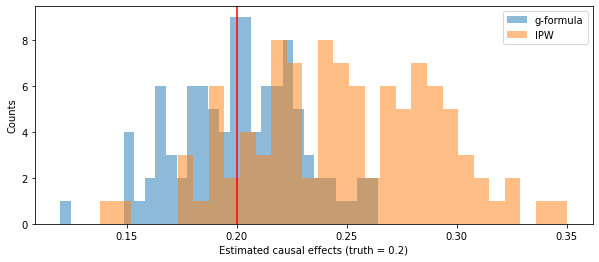

In [20]:
plt.figure(figsize=(10,4))
plt.hist(g_results, bins=30, label='g-formula', alpha=.5)
plt.hist(ipw_results, bins=30, label='IPW', alpha=.5)
plt.axvline(0.2, color='red')
plt.xlabel("Estimated causal effects (truth = 0.2)")
plt.ylabel("Counts")
plt.legend() 

In [21]:
print("g-formula CI:", np.quantile(g_results, 0.025), np.quantile(g_results, 0.975))
print("IPW CI:", np.quantile(ipw_results, 0.025), np.quantile(ipw_results, 0.975))

g-formula CI: 0.15077359730281087 0.2567550582437241
IPW CI: 0.1755984734485439 0.32654309184347435


Both the g-formula and IPW 95\% confidence intervals do not contain zero, which means that we would reject the null hypothesis and conclude that there is a causal effect. Thus, both methods recover the correct decision.